In [1]:
import morePVs_output as opm
import morePVs as mpv
import os
import en_utilities as um
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import shutil
import seaborn as sns

Looks at sites and plots:
* average summer/winter PV profile
    * for max and other systems
* average summer /winter load profile
    *averaged across 50VBs at the site

In [2]:
base_path='C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4'
load_base =  'C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\load_profiles'
pv_path = 'C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\pv_profiles'
ppath= 'C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_4\\analysis\\profile_plots'

In [3]:
#sites = ['A', 'B','C','D','E','F','G','H','I','J']
sites = ['F','G','H','I','J']

site_tag ={'A': 'a208_f12_cp34',
 'B': 'a104_f8_cp57',
 'C': 'a34_f4_cp33',
 'D': 'a138_f9_cp44',
 'E': 'a161_f7_cp38',
 'F': 'a20_f5_cp36',
 'G': 'a44_f4_cp17',
 'H': 'a52_f3_cp26',
 'I': 'a48_f4_cp09',
 'J': 'a26_f4_cp43'}

# load & PV files 
loadfolders = {}
for site in sites:
    loadfolders[site] = 'sh_t_all_site_'+site

pvfiles= {'F':['site_F_0_5kw.csv', 'site_F_1_0kw.csv', 'site_F_1_5kw.csv','site_F_max.csv'],
         'G':['site_G_0_5kw.csv', 'site_G_1_0kw.csv', 'site_G_1_5kw.csv','site_G_max.csv'],
          'H': ['site_H_0_5kw.csv', 'site_H_1_0kw.csv', 'site_H_1_5kw.csv','site_H_2_0kw.csv', 'site_H_2_5kw.csv','site_H_max.csv'],
          'I':['site_I_0_5kw.csv', 'site_I_1_0kw.csv', 'site_I_max.csv'],
         'J': ['site_J_0_5kw.csv', 'site_J_1_0kw.csv', 'site_J_1_5kw.csv','site_J_2_0kw.csv', 'site_J_2_5kw.csv','site_J_max.csv'] }
pvlabels = {'0_5kw': '0.5 kW/unit',
           '1_0kw': '1.0 kW/unit',
            '1_5kw': '1.5 kW/unit',
            '2_0kw': '2.0 kW/unit',
            '2_5kw': '2.5 kW/unit',
            'max': 'Max PV'}
months = {'summer':[1,2,3,10,11,12],
         'winter':  [4,5,6,7,8,9]}

numhouses={'A':208,'E':161, 'D':138,'B':104,'H':52,'I':48,'G':44,'C':34,'J':26,'F':20}

# get pv sizes for maximum pv systems
# -----------------------------------
maximums={}
pv_ref_file='C:\\Users\\z5044992\\Documents\\MainDATA\\DATA_EN_3\\reference\\capex_pv_lookup.csv'
pv_ref=pd.read_csv(pv_ref_file)
pv_ref = pv_ref.set_index('pv_cap_id')
for i in pv_ref.index:
    if 'max' in i and 'site' in i:
        site = um.find_between(i,'_','_')
        maximums[site] = pv_ref.loc[i,'kW']/numhouses[site]


        
fontsize = 12

In [4]:
pvfiles

{'F': ['site_F_0_5kw.csv',
  'site_F_1_0kw.csv',
  'site_F_1_5kw.csv',
  'site_F_max.csv'],
 'G': ['site_G_0_5kw.csv',
  'site_G_1_0kw.csv',
  'site_G_1_5kw.csv',
  'site_G_max.csv'],
 'H': ['site_H_0_5kw.csv',
  'site_H_1_0kw.csv',
  'site_H_1_5kw.csv',
  'site_H_2_0kw.csv',
  'site_H_2_5kw.csv',
  'site_H_max.csv'],
 'I': ['site_I_0_5kw.csv', 'site_I_1_0kw.csv', 'site_I_max.csv'],
 'J': ['site_J_0_5kw.csv',
  'site_J_1_0kw.csv',
  'site_J_1_5kw.csv',
  'site_J_2_0kw.csv',
  'site_J_2_5kw.csv',
  'site_J_max.csv']}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

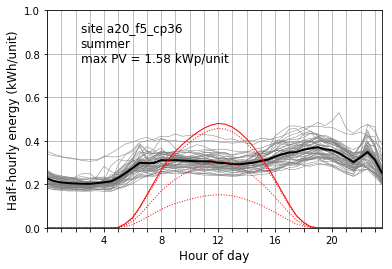

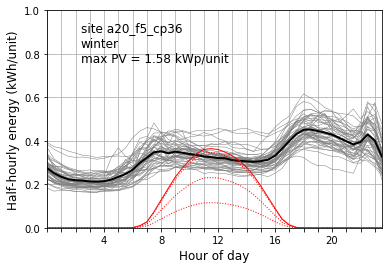

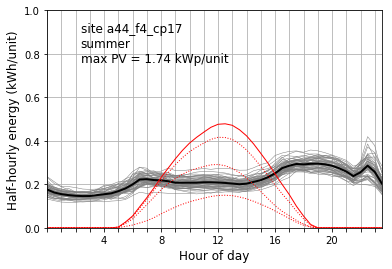

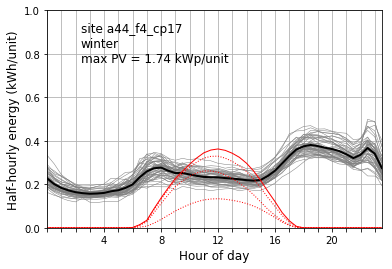

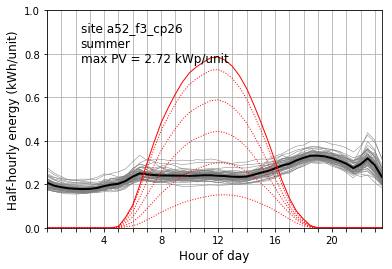

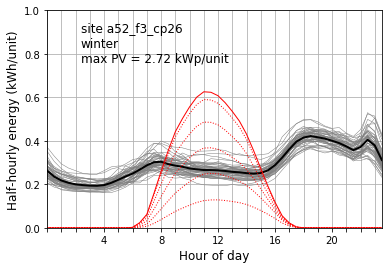

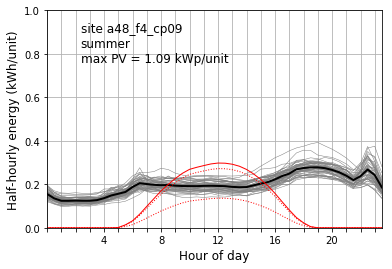

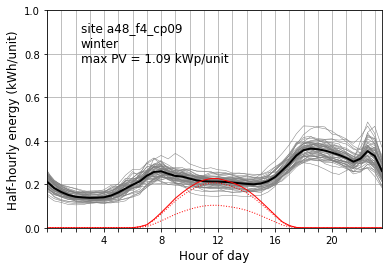

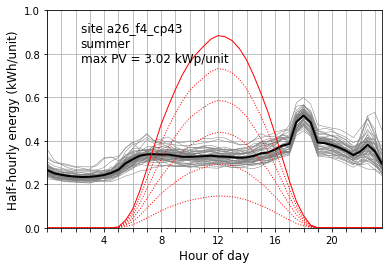

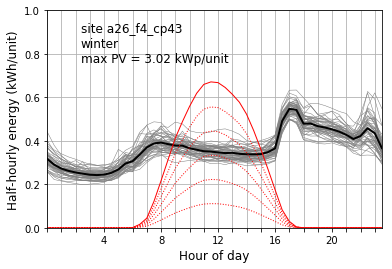

In [10]:
for site in sites:
    # get PV data
    dfps = pd.DataFrame()
    dfpw = pd.DataFrame()

    for pvfile in pvfiles[site]: 
        fp = os.path.join(pv_path,pvfile)
        df = pd.read_csv(fp, parse_dates = ['timestamp'])
        df = df.set_index('timestamp')
        pv = pvlabels[pvfile[7:-4]]
        summer = df.loc[df.index.month.isin(months['summer']),'pv']/numhouses[site]
        winter = df.loc[df.index.month.isin(months['winter']),'pv']/numhouses[site]
        dfps[pv] = summer.groupby(summer.index.time).mean()
        dfpw[pv] = winter.groupby(winter.index.time).mean()

    dfls = pd.DataFrame()
    dflw = pd.DataFrame()
    # get load data
    loadpath = os.path.join(load_base, loadfolders[site])
    flist = os.listdir(loadpath)
    for loadfile in flist:
        vb = flist.index(loadfile)
        lf = os.path.join(loadpath, loadfile)
        df = pd.read_csv(lf, parse_dates = ['timestamp'])
        df = df.set_index('timestamp')
        summer = df.loc[df.index.month.isin(months['summer'])].sum(axis=1)/numhouses[site]
        winter = df.loc[df.index.month.isin(months['winter'])].sum(axis=1)/numhouses[site]
        
        dfls[vb] = summer.groupby(summer.index.time).mean()
        dflw[vb] = winter.groupby(winter.index.time).mean()

    # Plot timeseries:
    max_y = 1.05 * max(dfps.max().max(), 
                       dfpw.max().max(),
                       dfls.max().max(),
                       dflw.max().max())

    # SUMMER
    # Plot Load timeseries 
    fig, ax = plt.subplots()
    for vb in dfls.columns:
        ax.plot(dfls.index, dfls[vb], color = 'grey', linewidth=0.5)
    ax.plot(dfls.index, dfls.mean(axis=1), color = 'black', linewidth=2)
    # Plot pv
    for pv in dfps.columns:
        if 'Max' in pv:
            ls = '-'
        else:
            ls = ':'
        ax.plot(dfps.index, dfps[pv], color = 'red', 
                linewidth = 1,
                linestyle = ls)

    # Make it look nice, innit
    ax.set_ylim(0,1)
    ax.set_xlim(0,23.5*3600)
    ax.set_xticks([x*3600 for x in range(24)])
    ax.set_xticklabels(['','','','','4','','','','8','','','','12','','','','16','','','','20','','',''])
    ax.set_xlabel("Hour of day", fontsize=fontsize)
    ax.set_ylabel("Half-hourly energy (kWh/unit)", fontsize=fontsize)
    ax.text(0.1,0.9,'site '+ site_tag[site], fontsize=fontsize,transform=ax.transAxes)
    ax.text(0.1,0.83,'summer', fontsize=fontsize,transform=ax.transAxes)
    ax.text(0.1,0.76,'max PV = '+str(round(maximums[site],2))+' kWp/unit', fontsize=fontsize,transform=ax.transAxes)
    ax.grid(True)


    pfile = os.path.join(ppath,'summer_'+ site + '.jpg')
    plt.savefig(pfile, dpi=1000)


    # WINTER
    # Plot Load timeseries 
    fig, ax = plt.subplots()
    for vb in dflw.columns:
        ax.plot(dflw.index, dflw[vb], color = 'grey', linewidth=0.5)
    ax.plot(dflw.index, dflw.mean(axis=1), color = 'black', linewidth=2)
    # Plot pv
    for pv in dfpw.columns:
        if 'Max' in pv:
            ls = '-'
        else:
            ls = ':'
        ax.plot(dfpw.index, dfpw[pv], color = 'red', 
                linewidth = 1,
                linestyle = ls)
    # Make it look nice, innit
    ax.set_ylim(0,1)
    ax.set_xlim(0,23.5*3600)
    ax.set_xticks([x*3600 for x in range(24)])
    ax.set_xticklabels(['','','','','4','','','','8','','','','12','','','','16','','','','20','','',''])
    ax.set_xlabel("Hour of day", fontsize=fontsize)
    ax.set_ylabel("Half-hourly energy (kWh/unit)", fontsize=fontsize)
    ax.text(0.1,0.9,'site '+ site_tag[site], fontsize=fontsize,transform=ax.transAxes)
    ax.text(0.1,0.83,'winter', fontsize=fontsize,transform=ax.transAxes)
    ax.text(0.1,0.76, 'max PV = '+str(round(maximums[site],2))+' kWp/unit', fontsize=fontsize,transform=ax.transAxes)
    ax.grid(True)
    
    pfile = os.path.join(ppath,'winter_'+ site + '.jpg')
    plt.savefig(pfile, dpi=1000)